# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
# from sklearn.naive_bayes import MultinomialNB, CategoricalNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC

import pickle

import psycopg2

/home/johnrivera/.virtualenvs/ds_reddit_build-L6udXIR8/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Read in data

In [2]:
with open("../database/secrets", "r") as file:
    secrets = [i.strip('\n') for i in file.readlines()]


def conn_curs():
    """
    makes a connection to the database dont worry these are dummy keys
    """

    connection = psycopg2.connect(dbname=secrets[4], user=secrets[4],
                                  password=secrets[5], host=secrets[6])
    cursor = connection.cursor()
    return connection, cursor

In [3]:
conn, curs = conn_curs()

In [4]:
df = pd.read_sql("SELECT * FROM posts", conn)

# Inspect

In [5]:
df.head()

,id,text,subreddit
0,1,Thousand Year Blood War Arc Anime Adaptation M...,bleach
1,2,Burn The Witch - Chapter 4 Discussion Thread #...,bleach
2,3,Let the journey begin.,bleach
3,4,"Since Ichigos an English Literature major, thi...",bleach
4,5,I just made these Ulquiorra customs for a clie...,bleach


In [6]:
df.shape

(21922, 3)

In [7]:
df.drop('id', axis=1, inplace=True)

In [8]:
df.subreddit.value_counts()

Berserk             300
GiftIdeas           300
BackYardChickens    300
declutter           300
ShingekiNoKyojin    300
                   ... 
dbz                 300
answers             300
needadvice          280
GetMotivated        220
translator          122
Name: subreddit, Length: 74, dtype: int64

# Model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.subreddit, test_size=0.33, random_state=42)

In [12]:
vect = TfidfVectorizer(max_df=.95, min_df=80)
vect.fit(df.text)
train_df = pd.DataFrame(vect.transform(X_train).todense(), columns=vect.get_feature_names())
train_df.head()
val_df = pd.DataFrame(vect.transform(X_test).todense(), columns=vect.get_feature_names())
val_df.head()

,000,10,100,11,12,13,14,15,16,17,...,young,younger,your,youre,yourself,youtu,youtube,youve,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
log_pipe = make_pipeline(TfidfVectorizer(max_df=.95,  min_df=80), LogisticRegression(random_state=42, n_jobs=-1))
log_pipe.fit(X_train, y_train);

In [14]:
print(f"Log train accuracy: {log_pipe.score(X_train, y_train)}")
print(f"Log val accuracy: {log_pipe.score(X_test, y_test)}")

Log train accuracy: 0.6261319534282018
Log val accuracy: 0.43524533517622666


# THIS WAS WITH LESS CATEGORIES

In [15]:
print(f"Log train accuracy: {log_pipe.score(X_train, y_train)}")
print(f"Log val accuracy: {log_pipe.score(X_test, y_test)}")

Log train accuracy: 0.6261319534282018
Log val accuracy: 0.43524533517622666


In [16]:
test = """AITA for having my husband out of the delivery room when he brought his mother instead of mine?
This happened a few weeks ago when I delivered my son. We had an agreement before that my husband would be by my side during the delivery.

When the moment comes, I suddenly had a change of mind and started to miss my mother desperately as if I would never see her again. I knew she had lessons that day but wanted her by my side, so I asked my husband to call and drive her here.

When my husband came back maybe an hour later, he came back with his mother, not mine. He explained that my mother was in a middle of a lecture and he was afraid that they could not make it in time before she sums it up, so he drove his own mother who lived nearer instead.

I got angry and started wailing uncontrollably, crying for my mother like a child. The nurses ended up removing him and I had no family beside me during the whole unpleasant process. I continued to cry even after seeing my son and only stopped when my mother finally arrived much later. According to her my husband did not call her, instead left her a message and she only saw it after dismissal.

Now thinking back that was extremely embarrassing and I had no idea how I lost it like that. I feel sorry that he was not able to witness the process because of my last minute change of mind(it was supposed to be just me and him) and he expressed his disappointment too. However, I am also angry that he did not bother to make an effort to let me see my mother when I felt I needed her and instead took this chance to bring his own mother. I guess both of us feel betrayed to some extend, but which one of us is the AH? I want to know."""

In [17]:
log_pipe.predict(["AITA"])[0]

'cats'

# Pickle mvp log pipe

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC

In [27]:
with open("../models/mvp_log_pipe", "wb") as file:
    pickle.dump(log_pipe, file)

In [28]:
forest = RandomForestClassifier(n_jobs=-1)
forest.fit(train_df, y_train);

In [29]:
print(f"Train accuracy: {forest.score(train_df, y_train)}")
print(f"Val accuracy: {forest.score(val_df, y_test)}")

Train accuracy: 0.969292571662014
Val accuracy: 0.43441603317208016


In [30]:
mnb = MultinomialNB()
mnb.fit(train_df, y_train);

In [31]:
print(f"Train accuracy: {mnb.score(train_df, y_train)}")
print(f"Val accuracy: {mnb.score(val_df, y_test)}")

Train accuracy: 0.5886157826649417
Val accuracy: 0.4201796821008984


In [ ]:
# svc = SVC()
# svc.fit(train_df, y_train);

In [ ]:
# print(f"Train accuracy: {svc.score(train_df, y_train)}")
# print(f"Val accuracy: {svc.score(val_df, y_test)}")

In [36]:
sgd = SGDClassifier(n_jobs=-1)
sgd.fit(train_df, y_train);

In [37]:
print(f"Train accuracy: {sgd.score(train_df, y_train)}")
print(f"Val accuracy: {sgd.score(val_df, y_test)}")

Train accuracy: 0.7424933614761353
Val accuracy: 0.4638562543192813


# Consider SVM and SGD

In [38]:
decom = PCA(3).fit(train_df)
pca = decom.transform(train_df)

In [39]:
pca_df = pd.DataFrame(pca)
print(pca_df.isnull().sum())
print(pca_df.shape, y_train.shape)
pca_df.head()

0    0
1    0
2    0
dtype: int64
(14687, 3) (14687,)


,0,1,2
0,0.235189,-0.037462,-0.191415
1,-0.101099,-0.069523,-0.046165
2,0.055862,-0.000440,0.071355
3,-0.114373,0.112502,0.095718
4,0.264412,-0.064056,0.082885


In [40]:
plot_df = pd.concat([pca_df.reset_index(), pd.DataFrame(y_train).reset_index()], axis=1)

In [41]:
plot_df.head()

,index,0,1,2,index,subreddit
0,0,0.235189,-0.037462,-0.191415,17184,needadvice
1,1,-0.101099,-0.069523,-0.046165,15391,NoStupidQuestions
2,2,0.055862,-0.000440,0.071355,15278,NoStupidQuestions
3,3,-0.114373,0.112502,0.095718,4093,RBI
4,4,0.264412,-0.064056,0.082885,7316,legaladvice


In [42]:
plot_df.drop('index', axis=1, inplace=True)

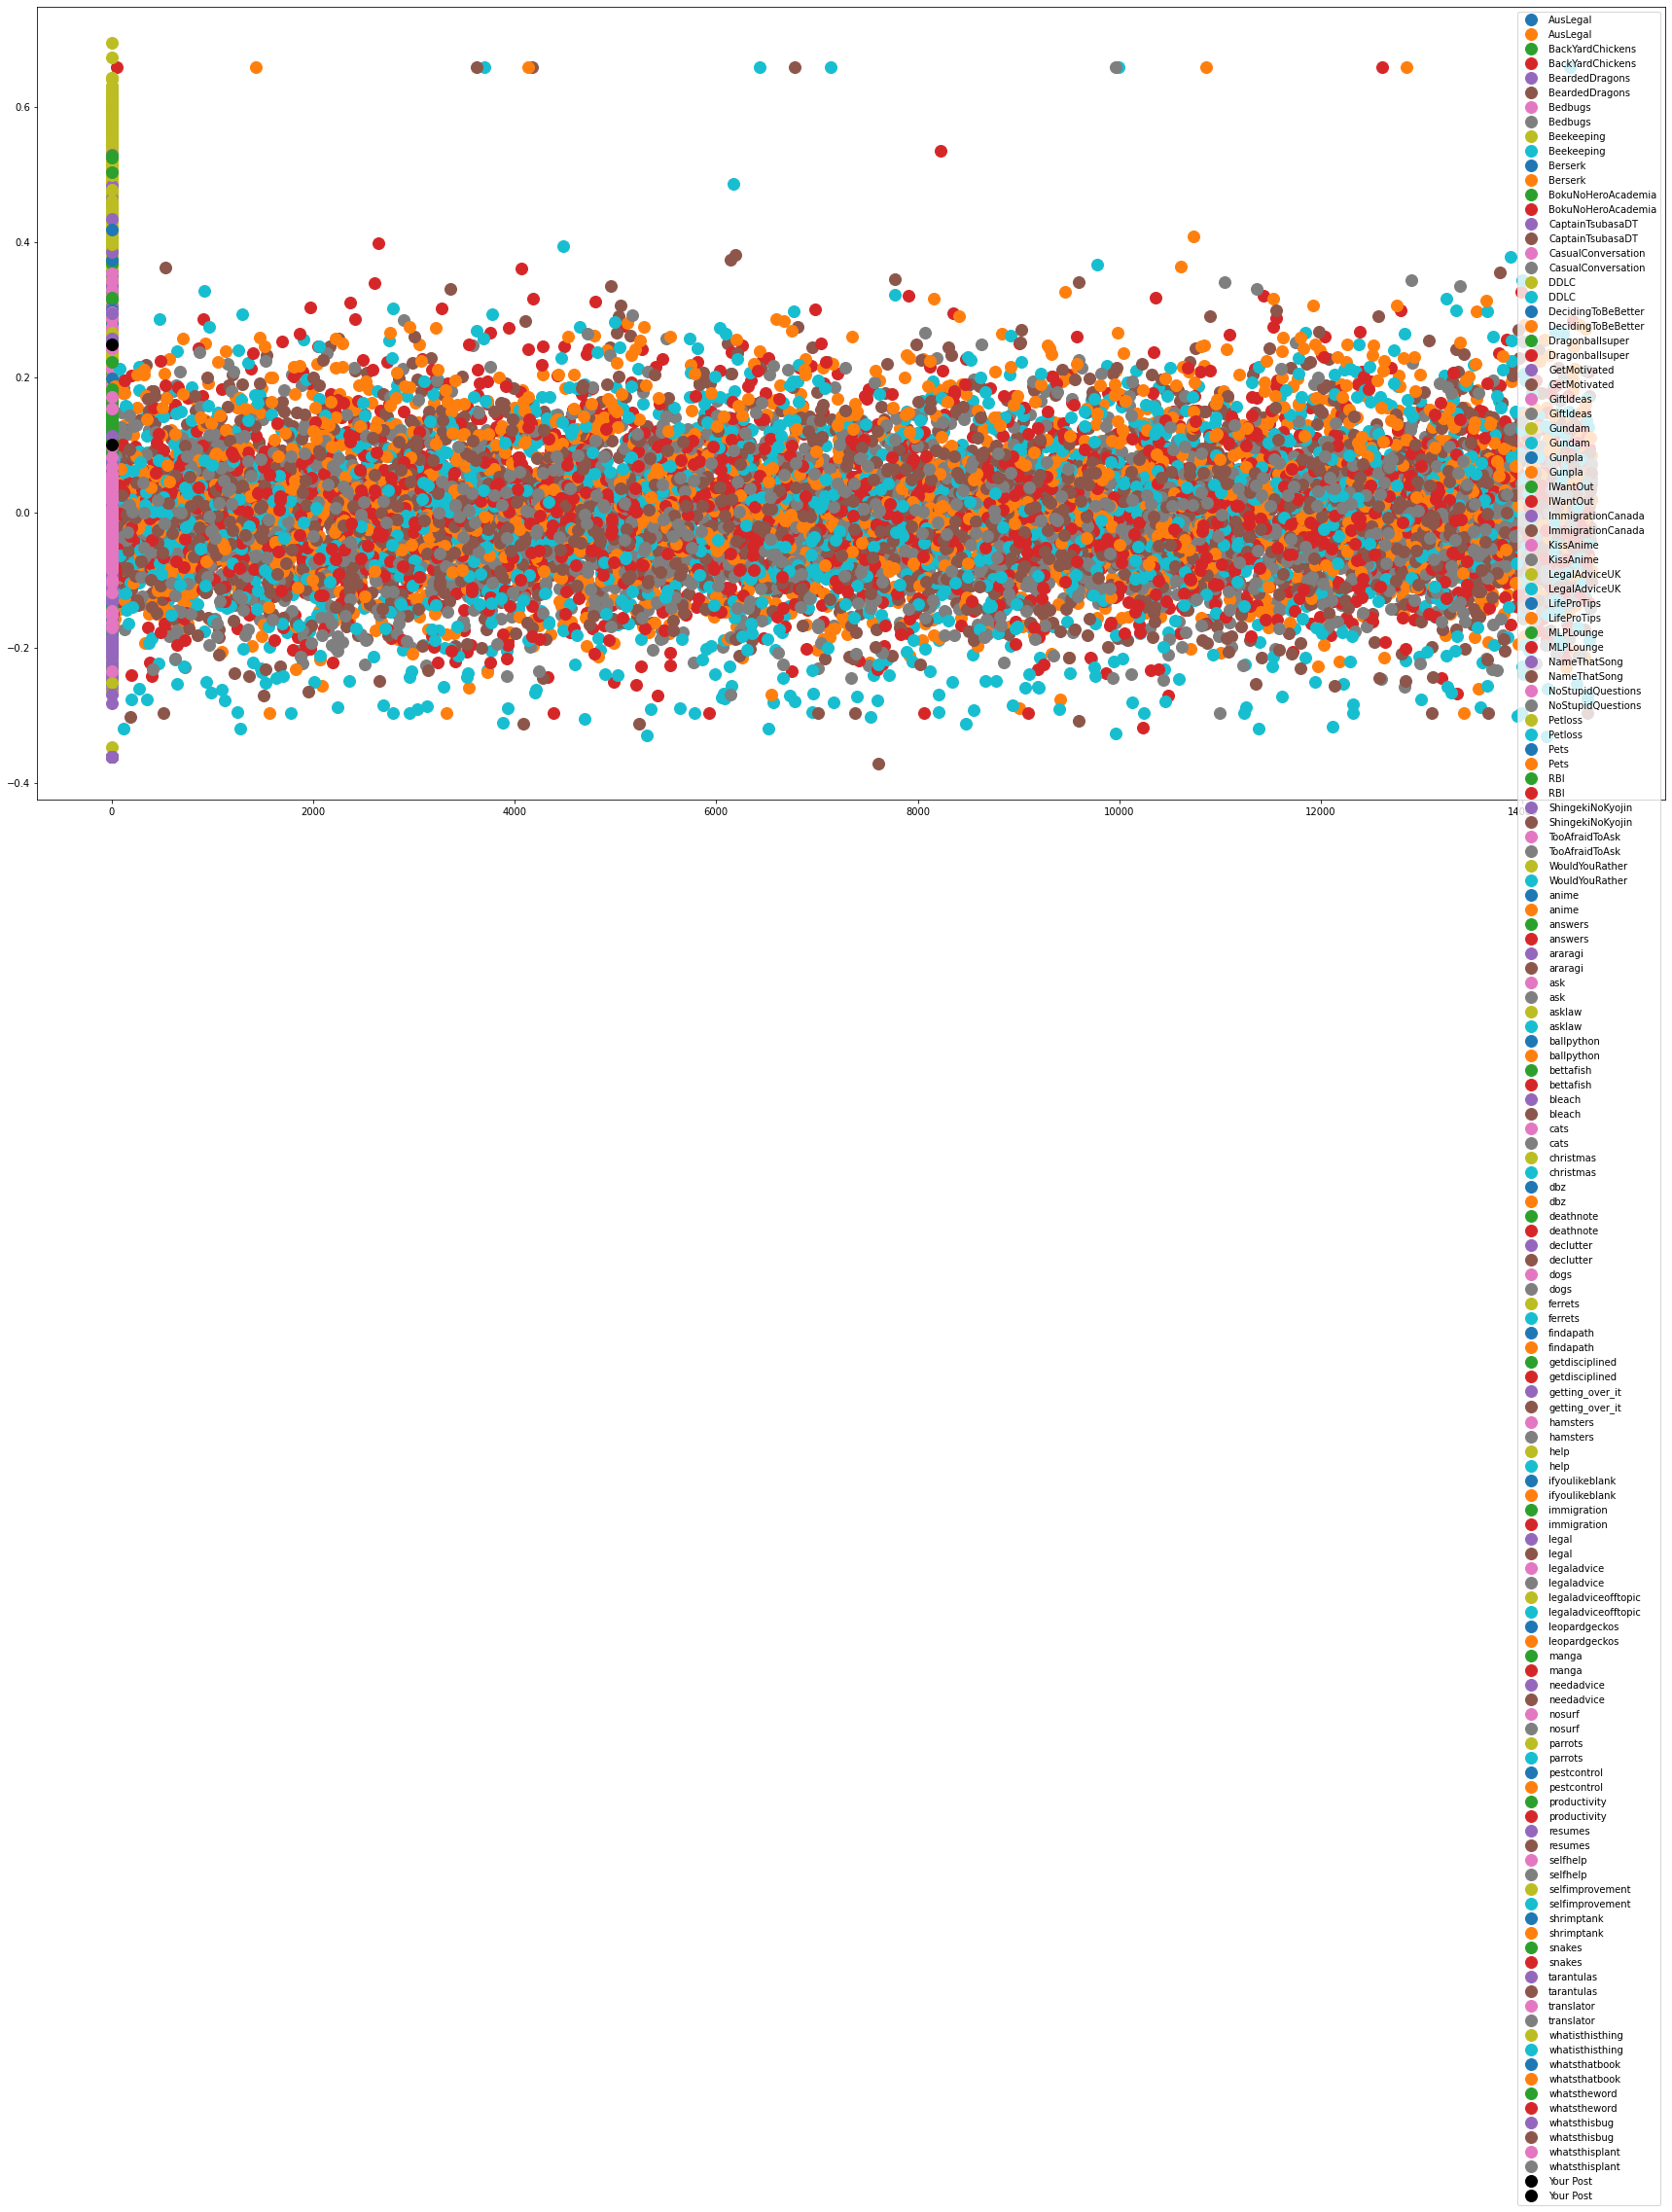

In [44]:
groups = plot_df.groupby('subreddit')

# Plot
fig, ax = plt.subplots()

fig.set_size_inches(30, 15)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group[0], group[1],group[2], marker='o', linestyle='', ms=12, label=name)

x = decom.transform(vect.transform(["Am i the asshole"]).todense())[0]
ax.plot(x[0],x[1],x[2],marker="o", linestyle="", ms=12, label="Your Post", c="black")

ax.legend()

plt.show()

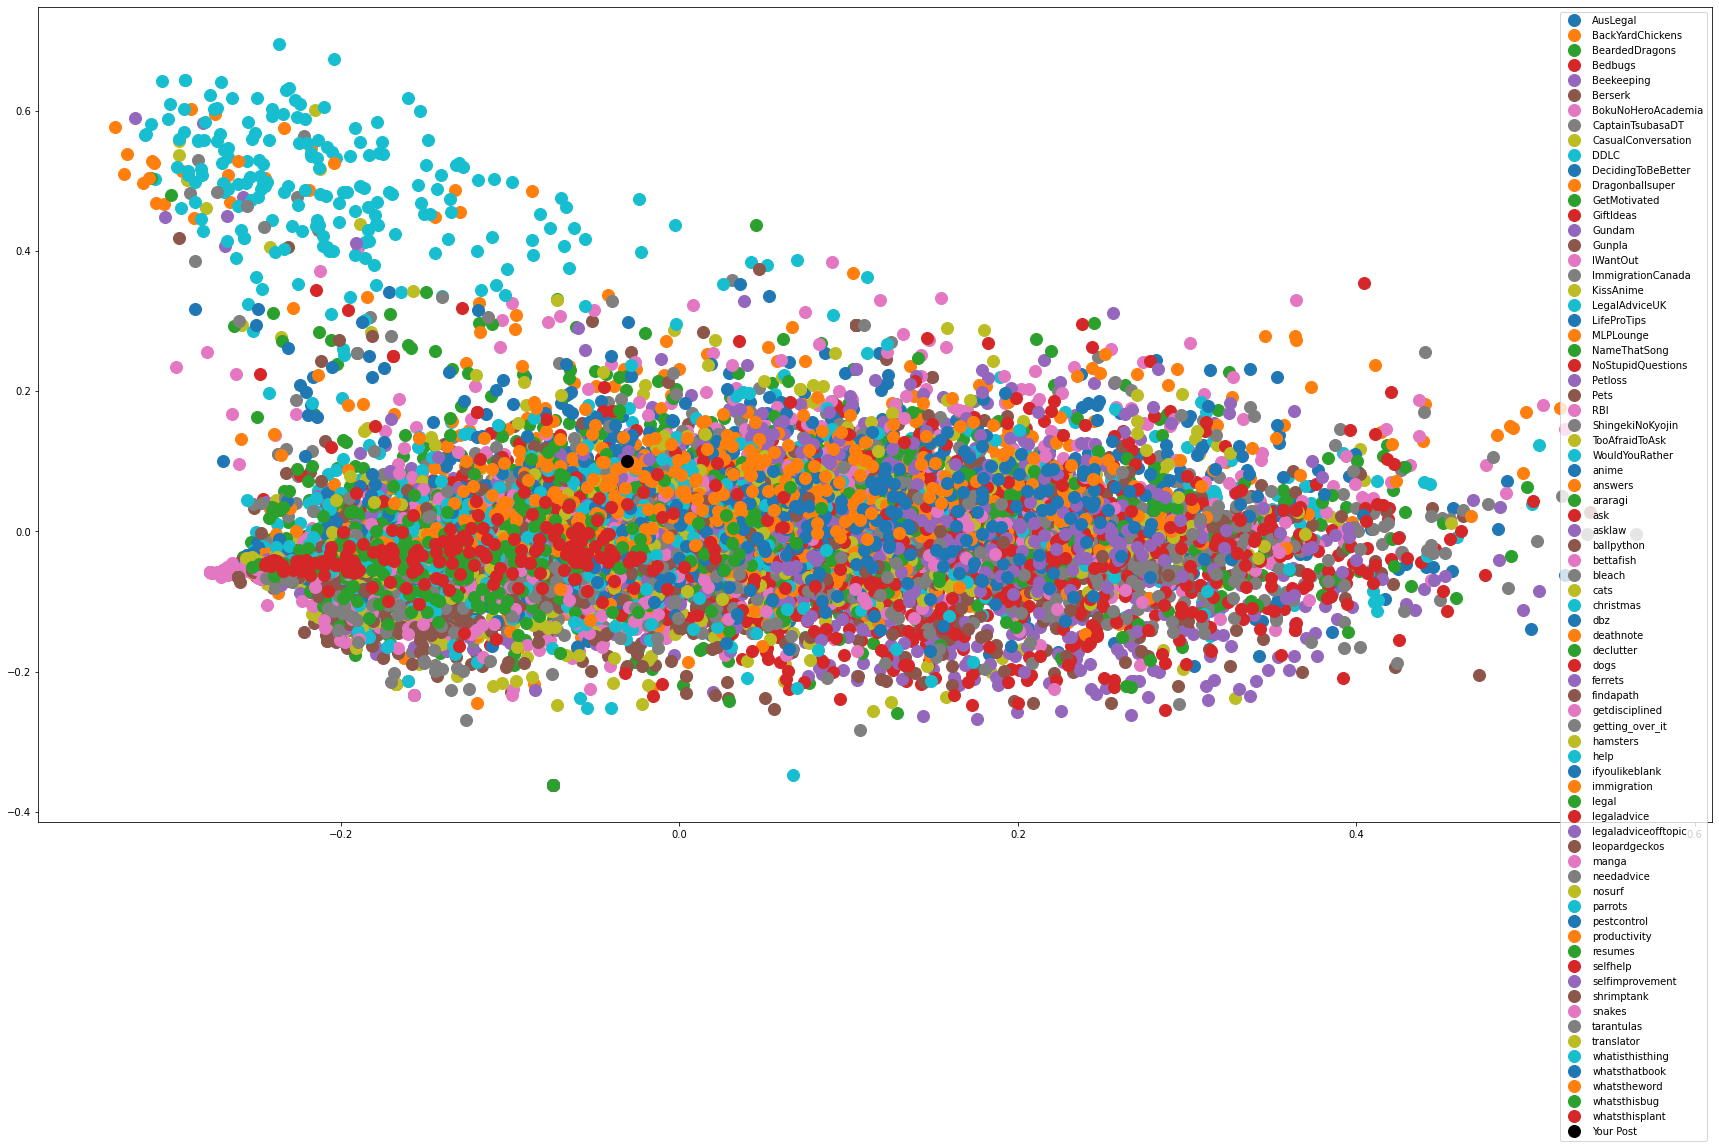

In [45]:
groups = plot_df.groupby('subreddit')

# Plot
fig, ax = plt.subplots()

fig.set_size_inches(30, 15)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group[0], group[1], marker='o', linestyle='', ms=12, label=name)

x = decom.transform(vect.transform(["Am i the asshole"]).todense())[0]
ax.plot(x[0],x[1],marker="o", linestyle="", ms=12, label="Your Post", c="black")

ax.legend()

plt.show()


In [46]:
train_df.shape

(14687, 2012)